<a href="https://colab.research.google.com/github/p25-c4/kurly_project/blob/main/0321_SG_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [ ]:
!pip install xgboost

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

W: Failed to fetch https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu/dists/jammy/InRelease  503  Service Unavailable [IP: 185.125.190.80 443]
W: Failed to fetch https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu/dists/jammy/InRelease  503  Service Unavailable [IP: 185.125.190.80 443]
W: Failed to fetch https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu/dists/jammy/InRelease  503  Service Unavailable [IP: 185.125.190.80 443]
W: Failed to fetch https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/dists/jammy/InRelease  503  Service Unavailable [IP: 185.125.190.80 443]
W: Some index files failed to download. They have been ignored, or old ones used instead.
Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fon

In [37]:
import matplotlib

# 맑은 고딕 적용
matplotlib.rc("font", family = "NanumGothic")
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

# 실행결과 경고메시지 출력 제외
import warnings

warnings.filterwarnings('ignore')

# 데이터 구성:Series, DataFrame
import numpy as np
import pandas as pd

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# 평가 지수
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

In [ ]:
import os
os.chdir("/content/drive/MyDrive/BigData/early_project")

# Load the data

In [ ]:
# 데이터 불러오기
df = pd.read_csv("df_model.csv")
df.tail(10)

,Date,rate_delay,rate_female,rate_2030s,target
1085,2023-12-22,0.018601,0.660762,0.705049,NaN
1086,2023-12-23,0.000000,0.457143,0.671429,NaN
1087,2023-12-24,0.023691,0.562344,0.738155,NaN
1088,2023-12-25,0.012963,0.617593,0.756481,NaN
1089,2023-12-26,0.015530,0.594868,0.661040,NaN
1090,2023-12-27,0.040787,0.579024,0.756009,NaN
1091,2023-12-28,0.026260,0.606813,0.665720,NaN
1092,2023-12-29,0.032045,0.592837,0.715363,NaN
1093,2023-12-30,0.000000,0.606383,0.680851,NaN
1094,2023-12-31,0.037841,0.561491,0.765164,NaN


In [ ]:
# Date 열 삭제
df_raw = df.drop('Date', axis = 1)
df_raw

,rate_delay,rate_female,rate_2030s,target
0,0.024611,0.560233,0.664508,1303250.0
1,0.037942,0.604011,0.604011,22230200.0
2,0.000000,0.794872,0.512821,10492740.0
3,0.038515,0.625058,0.670534,18678110.0
4,0.025445,0.592875,0.676845,19482900.0
...,...,...,...,...
1090,0.040787,0.579024,0.756009,NaN
1091,0.026260,0.606813,0.665720,NaN
1092,0.032045,0.592837,0.715363,NaN
1093,0.000000,0.606383,0.680851,NaN


In [ ]:
# train & test용 데이터와 prediction용 데이터로 분리
df_train_test = df_raw[df_raw['target'].notnull()]
df_train_test_x = df_train_test.drop('target', axis=1)
df_train_test_y = df_train_test['target']
df_prediction = df_raw[df_raw['target'].isnull()]
df_prediction_x = df_prediction.drop('target', axis=1)
df_prediction_y = df_prediction['target']
print("train_test_x shape: ", df_train_test_x.shape)
print("train_test_y shape: ", df_train_test_y.shape)
print("prediction_x shape: ", df_prediction_x.shape)
print("prediction_y shape: ", df_prediction_y.shape)

train_test_x shape:  (730, 3)
train_test_y shape:  (730,)
prediction_x shape:  (365, 3)
prediction_y shape:  (365,)


# train test split

In [ ]:
# train_test 분리
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_train_test_x, df_train_test_y , test_size = 0.3)
print("train_x shape: ", df_train_x.shape)
print("train_y shape: ", df_train_y.shape)
print("test_x shape: ", df_test_x.shape)
print("test_y shape: ", df_test_y.shape)

train_x shape:  (511, 3)
train_y shape:  (511,)
test_x shape:  (219, 3)
test_y shape:  (219,)


## Multi Variate Regression

In [26]:
df_train = pd.concat([df_train_x.reset_index(drop=True) , df_train_y.reset_index(drop=True)], axis=1)

In [29]:
# 선형 회귀 분석 : formula(y ~ X1 + X2 + ...) 이용. 상수항(Intercept) 자동 추가.
reg_model = smf.ols(formula = "target ~ rate_delay + rate_female + rate_2030s", data = df_train)
# 적합
reg_result = reg_model.fit()
print(reg_result.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9126
Date:                Wed, 20 Mar 2024   Prob (F-statistic):              0.435
Time:                        17:59:35   Log-Likelihood:                -8786.4
No. Observations:                 511   AIC:                         1.758e+04
Df Residuals:                     507   BIC:                         1.760e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.197e+07   4.61e+06      2.595      

In [33]:
# 설명변수간의 다중공선성 확인 : 설명변수 데이터 생성 및 상수항 추가
df_train_x = df_train.drop('target', axis = 1)
# statsmodels의 상수항 추가 함수 적용
df_train_x_const = sm.add_constant(df_train_x)
# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i) \
                 for i in range(df_train_x_const.shape[1])]
# VIF 정렬
df_vif.sort_values("VIF", ascending = True).round(2)



,variable,VIF
2,rate_female,1.02
3,rate_2030s,1.02
1,rate_delay,1.03
0,const,213.92


In [34]:
# 선형 회귀 분석(유의하지 않은 변수 중 p-value가 가장 큰 것을 하나씩 반복적으로 제거)
# rate_female 제거
reg_model = smf.ols(formula = "target ~ rate_delay + rate_2030s", data = df_train)
# 적합
reg_result = reg_model.fit()
print(reg_result.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.304
Date:                Wed, 20 Mar 2024   Prob (F-statistic):              0.272
Time:                        18:01:58   Log-Likelihood:                -8786.4
No. Observations:                 511   AIC:                         1.758e+04
Df Residuals:                     508   BIC:                         1.759e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.313e+07   3.36e+06      3.904      0.0

In [35]:
# rate_delay 제거
reg_model = smf.ols(formula = "target ~ rate_2030s", data = df_train)
# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3166
Date:                Wed, 20 Mar 2024   Prob (F-statistic):              0.574
Time:                        18:02:03   Log-Likelihood:                -8787.6
No. Observations:                 511   AIC:                         1.758e+04
Df Residuals:                     509   BIC:                         1.759e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.437e+07   3.26e+06      4.405      0.0

- 마지막 남은 변수도 p-value가 0.574로 매우 높다.
- 회귀 적합이 의미가 없다.

## RandomForest

In [38]:
rf_uncustomized = RandomForestRegressor()
rf_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.847
Score on test set: 0.091


In [39]:
train_score = []; test_score = []
# n_estimatos: 트리 수 변경: 1~100
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

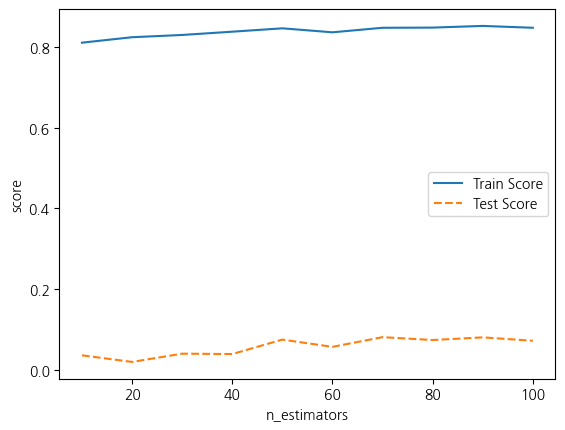

In [40]:
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

In [42]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf = [n_leaf for n_leaf in range(1, 40)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(                              min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score


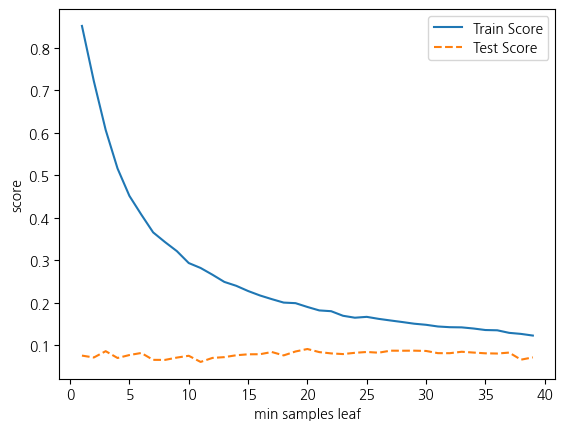

In [43]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

In [45]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분할하기 위한 노드의 최소 자료 수
para_split = [n_split * 2for n_split in range(2, 41)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

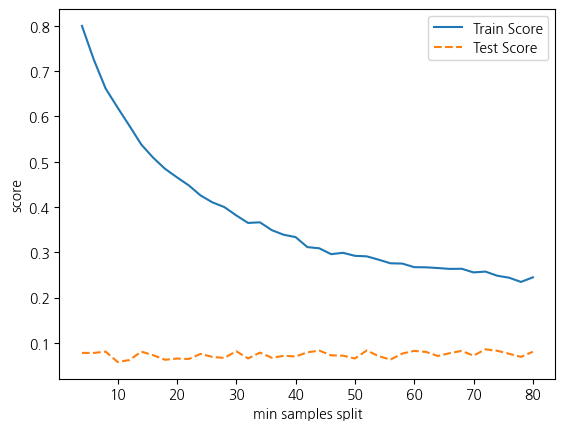

In [46]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

- hyperparameter를 조정해가면서 여러 조합을 살펴보아도
- R-squared가 0.1 이상으로 올라가지 않음.
- 모델 설명력이 없음.

# XGB
    - lr, gamma만 조절

In [ ]:
# 기본 모델 생성
xgb_uncust = XGBRegressor()
xgb_uncust.fit(df_train_x, df_train_y)

# train 데이터 성능
print("train R-squared: ", xgb_uncust.score(df_train_x, df_train_y))
print("test R-squared: ", xgb_uncust.score(df_test_x, df_test_y))

train R-squared:  0.9946584865225144
test R-squared:  -0.0973226046249176


## lr

In [ ]:
# train 및 test 정확도 결과 저장용
train_r2 = []; test_r2 = []
# max_depth: 최대 깊이 변경. 1~10
para_lr = [lr * 0.1 for lr in range(1, 11)]

for lr in para_lr:
    xgb = XGBRegressor(lr = lr)
    xgb.fit(df_train_x, df_train_y)
    train_r2.append(xgb.score(df_train_x, df_train_y))
    test_r2.append(xgb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_r2_lr = pd.DataFrame()
df_r2_lr["lr"] = para_lr
df_r2_lr["Train R2"] = train_r2
df_r2_lr["Test R2"] = test_r2

df_r2_lr.round(3)

,lr,Train R2,Test R2
0,0.1,0.995,-0.097
1,0.2,0.995,-0.097
2,0.3,0.995,-0.097
3,0.4,0.995,-0.097
4,0.5,0.995,-0.097
5,0.6,0.995,-0.097
6,0.7,0.995,-0.097
7,0.8,0.995,-0.097
8,0.9,0.995,-0.097
9,1.0,0.995,-0.097


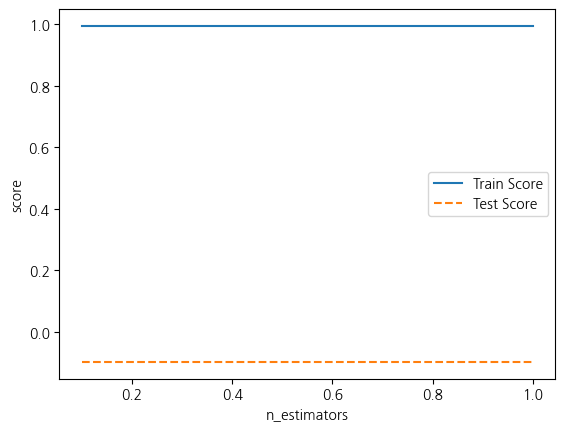

In [ ]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_r2, linestyle = "-", label = "Train Score")
plt.plot(para_lr, test_r2, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

## gamma

In [ ]:
XGBRegressor()

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# train 및 test 정확도 결과 저장용
train_r2 = []; test_r2 = []
# max_depth: 최대 깊이 변경. 1~10
para_gamma = [gamma for gamma in range(0, 11)]

for gamma in para_gamma:
    xgb = XGBRegressor(gamma = gamma)
    xgb.fit(df_train_x, df_train_y)
    train_r2.append(xgb.score(df_train_x, df_train_y))
    test_r2.append(xgb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_r2_gamma = pd.DataFrame()
df_r2_gamma["gamma"] = para_gamma
df_r2_gamma["Train R2"] = train_r2
df_r2_gamma["Test R2"] = test_r2

df_r2_gamma.round(3)

,gamma,Train R2,Test R2
0,0,0.995,-0.097
1,1,0.995,-0.097
2,2,0.995,-0.097
3,3,0.995,-0.097
4,4,0.995,-0.097
5,5,0.995,-0.097
6,6,0.995,-0.097
7,7,0.995,-0.097
8,8,0.995,-0.097
9,9,0.995,-0.097


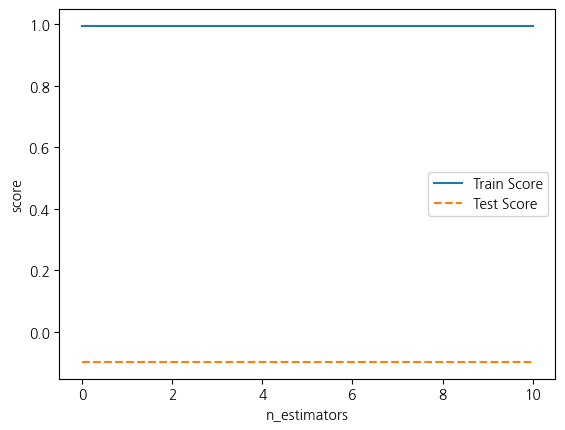

In [ ]:
# 모델 설명력 그래프 확인
plt.plot(para_gamma, train_r2, linestyle = "-", label = "Train Score")
plt.plot(para_gamma, test_r2, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

In [ ]:
xgb = XGBRegressor()
xgb.fit(df_train_x, df_train_y)
y_pred = xgb.predict(df_test_x)

print("MSE: ", mse(y_pred, df_test_y))
print("RMSE: ", np.sqrt(mse(y_pred, df_test_y)))
print("MAE: ", mae(y_pred, df_test_y))
print("MAPE: ", mape(y_pred, df_test_y))

MSE:  70500442568572.28
RMSE:  8396454.16640693
MAE:  6460649.277183219
MAPE:  1.4447961827628413


- test R-squared가 음수임.
- SSE가 SST보다 클 떄 나타나는 현상으로,
- 예측값이 표본평균보다도 못한 수준으로 보임.
- 모델 설명력이 없음.